In [3]:
# basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# sklearn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, KFold, cross_val_predict, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.svm import SVR
from sklearn.cluster import KMeans

#others
from xgboost import XGBRegressor
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
import time
import xarray as xr
import sherpa
import sys

# Variables from config file
sys.path.append('/home/yusukemh/github/yusukemh/StatisticalDownscaling/codes/')
from config import BASE_DIR, FILE_NAMES, LABELS, ATTRIBUTES


In [2]:
# Load the dataset
df_metadata = pd.read_excel(f"{BASE_DIR}/FilledDataset2012.xlsx", sheet_name="Header")


df_data_original = (
    pd.read_csv(f"{BASE_DIR}/dataset.csv")
    .drop(labels=["data_in", "lat", "lon", "Lon_DD_updated", "Lat_DD", "Lon_DD"], axis=1)
    .rename(
    {
        "air"  : "air2m",
        "air.1": "air1000_500",
        "hgt"  : "hgt500",
        "hgt.1": "hgt1000",
        "omega": "omega500",
        "pottmp": "pottemp1000-500",
        "pottmp.1": "pottemp1000-850",
        "pr_wtr": "pr_wtr",
        "shum": "shum-uwnd-700",
        "shum.1": "shum-uwnd-925",
        "shum.2": "shum-vwnd-700",
        "shum.3": "shum-vwnd-950",
        "shum.4": "shum700",
        "shum.5": "shum925",
        "skt": "skt",
        "slp": "slp"
    }
    , axis=1)
    
)

df_interp_100 = (# this will be the base dataset that all others merge onto
    pd.read_csv(f"{BASE_DIR}/dataset_interp_100.csv")
    .rename(
        {
            "air2m"      :"i100_air2m",
            "air1000_500":"i100_air1000_500",
            "hgt500"     :"i100_hgt500",
            "hgt1000"    :"i100_hgt1000",
            "omega500"   :"i100_omega500",
            "pottemp1000-500":"i100_pottemp1000-500",
            "pottemp1000-850":"i100_pottemp1000-850",
            "pr_wtr"       :"i100_pr_wtr",
            "shum-uwnd-700":"i100_shum-uwnd-700",
            "shum-uwnd-925":"i100_shum-uwnd-925",
            "shum-vwnd-700":"i100_shum-vwnd-700",
            "shum-vwnd-950":"i100_shum-vwnd-950",
            "shum700"      :"i100_shum700",
            "shum925"      :"i100_shum925",
            "skt":"i100_skt",
            "slp":"i100_slp"
        },
        axis=1
    )
)

df_interp_50 = (
    pd.read_csv(f"{BASE_DIR}/dataset_interp_50.csv")
    .drop(labels=["data_in", "elevation", "lat", "lon", "name", "Observer", "NumMos", "MinYear", "MaxYear", "Status2010"], axis=1)
    .rename(
        {
            "air2m"      :"i50_air2m",
            "air1000_500":"i50_air1000_500",
            "hgt500"     :"i50_hgt500",
            "hgt1000"    :"i50_hgt1000",
            "omega500"   :"i50_omega500",
            "pottemp1000-500":"i50_pottemp1000-500",
            "pottemp1000-850":"i50_pottemp1000-850",
            "pr_wtr"       :"i50_pr_wtr",
            "shum-uwnd-700":"i50_shum-uwnd-700",
            "shum-uwnd-925":"i50_shum-uwnd-925",
            "shum-vwnd-700":"i50_shum-vwnd-700",
            "shum-vwnd-950":"i50_shum-vwnd-950",
            "shum700"      :"i50_shum700",
            "shum925"      :"i50_shum925",
            "skt":"i50_skt",
            "slp":"i50_slp"
        },
        axis=1
    )
)

df_6grids = (
    pd.read_csv(f"{BASE_DIR}/dataset_5girds.csv")
    .drop(
        labels=["data_in", "elevation", "lat", "lon", "name", "Observer", "NumMos", "MinYear", "MaxYear", "Status2010"],
        axis=1
    ).drop(
        labels=[
            "air2m", "air1000_500", "hgt500", "hgt1000", "omega500",
            "pottemp1000-500", "pottemp1000-850", "pr_wtr", "shum-uwnd-700",
            "shum-uwnd-925", "shum-vwnd-700", "shum-vwnd-950", "shum700",
            "shum925", "skt", "slp"
        ],
        axis=1
    ).rename(
        {
            "air2m"      :"i6grids_air2m",
            "air1000_500":"i6grids_air1000_500",
            "hgt500"     :"i6grids_hgt500",
            "hgt1000"    :"i6grids_hgt1000",
            "omega500"   :"i6grids_omega500",
            "pottemp1000-500":"i6grids_pottemp1000-500",
            "pottemp1000-850":"i6grids_pottemp1000-850",
            "pr_wtr"       :"i6grids_pr_wtr",
            "shum-uwnd-700":"i6grids_shum-uwnd-700",
            "shum-uwnd-925":"i6grids_shum-uwnd-925",
            "shum-vwnd-700":"i6grids_shum-vwnd-700",
            "shum-vwnd-950":"i6grids_shum-vwnd-950",
            "shum700"      :"i6grids_shum700",
            "shum925"      :"i6grids_shum925",
            "skt":"i6grids_skt",
            "slp":"i6grids_slp"
        },
        axis=1
    )
)

In [3]:
df_combined = (
    df_interp_100
    .merge(right=df_data_original, left_on=["skn", "year", "month"], right_on=["skn", "year", "month"])
    .merge(right=df_interp_50, left_on=["skn", "year", "month"], right_on=["skn", "year", "month"])
    .merge(right=df_6grids, left_on=["skn", "year", "month"], right_on=["skn", "year", "month"])
    
)

In [4]:
train, valid, test = (0, 0, 0)
df_train = []
df_valid = []
df_test = []

for name, group in df_combined.groupby(by=["year", "month"]):
    # print(name, len(group))
    label = np.random.choice(a=["train", "valid", "test"], size=1, replace=True, p=[0.6, 0.2, 0.2])
    if label == "train":
        train += len(group)
        df_train.append(group)
    elif label == "valid":
        valid += len(group)
        df_valid.append(group)
    else:
        test += len(group)
        df_test.append(group)

(1948, 1) 1164
(1948, 2) 1158
(1948, 3) 1165
(1948, 4) 1153
(1948, 5) 1156
(1948, 6) 1143
(1948, 7) 1156
(1948, 8) 1152
(1948, 9) 1149
(1948, 10) 1156
(1948, 11) 1168
(1948, 12) 1183
(1949, 1) 1188
(1949, 2) 1192
(1949, 3) 1191
(1949, 4) 1172
(1949, 5) 1181
(1949, 6) 1165
(1949, 7) 1160
(1949, 8) 1161
(1949, 9) 1166
(1949, 10) 1186
(1949, 11) 1181
(1949, 12) 1196
(1950, 1) 1198
(1950, 2) 1204
(1950, 3) 1204
(1950, 4) 1178
(1950, 5) 1185
(1950, 6) 1189
(1950, 7) 1202
(1950, 8) 1197
(1950, 9) 1202
(1950, 10) 1209
(1950, 11) 1199
(1950, 12) 1196
(1951, 1) 1204
(1951, 2) 1204
(1951, 3) 1207
(1951, 4) 1191
(1951, 5) 1205
(1951, 6) 1186
(1951, 7) 1205
(1951, 8) 1202
(1951, 9) 1189
(1951, 10) 1199
(1951, 11) 1214
(1951, 12) 1210
(1952, 1) 1211
(1952, 2) 1210
(1952, 3) 1213
(1952, 4) 1196
(1952, 5) 1194
(1952, 6) 1181
(1952, 7) 1201
(1952, 8) 1186
(1952, 9) 1190
(1952, 10) 1203
(1952, 11) 1183
(1952, 12) 1192
(1953, 1) 1208
(1953, 2) 1198
(1953, 3) 1199
(1953, 4) 1189
(1953, 5) 1187
(1953, 6) 

In [14]:
df_train = pd.concat(df_train).reset_index().drop(labels=["index"], axis=1)
df_valid = pd.concat(df_valid).reset_index().drop(labels=["index"], axis=1)
df_test  = pd.concat(df_test).reset_index().drop(labels=["index"], axis=1)

In [15]:
df_train.to_csv(f"{BASE_DIR}/train.csv", index=False)
df_valid.to_csv(f"{BASE_DIR}/valid.csv", index=False)
df_test.to_csv(f"{BASE_DIR}/test.csv", index=False)

# Append season_wet and season_dry attribute

In [5]:
# load datasets
df_train = pd.read_csv(f"{BASE_DIR}/train.csv")
df_valid = pd.read_csv(f"{BASE_DIR}/valid.csv")
df_test = pd.read_csv(f"{BASE_DIR}/test.csv")

# Nov-Apr = "wet", May-Oct = "dry"
wet = [11, 12, 1, 2, 3, 4]
dry = [5, 6, 7, 8, 9, 10]
df_train['season_dry'] = df_train.apply(lambda row: 1 if row.month in dry else 0, axis=1)
df_train['season_wet'] = df_train.apply(lambda row: 1 if row.month in wet else 0, axis=1)

df_valid['season_dry'] = df_valid.apply(lambda row: 1 if row.month in dry else 0, axis=1)
df_valid['season_wet'] = df_valid.apply(lambda row: 1 if row.month in wet else 0, axis=1)

df_test['season_dry'] = df_test.apply(lambda row: 1 if row.month in dry else 0, axis=1)
df_test['season_wet'] = df_test.apply(lambda row: 1 if row.month in wet else 0, axis=1)


In [7]:
df_train.to_csv(f"{BASE_DIR}/train.csv", index=False)
df_valid.to_csv(f"{BASE_DIR}/valid.csv", index=False)
df_test.to_csv(f"{BASE_DIR}/test.csv", index=False)

# Append fold id for cross_val_predict using aggregate model
### Make sure to set aside the test data, which will not be included in the cross_val_predict?

In [14]:
# load datasets
df_train = pd.read_csv(f"{BASE_DIR}/train.csv")
df_valid = pd.read_csv(f"{BASE_DIR}/valid.csv")
df_test = pd.read_csv(f"{BASE_DIR}/test.csv")
df_combined = pd.concat([df_train, df_valid, df_test])

In [50]:
n_folds = 6

df_len_by_month = pd.DataFrame(df_combined.groupby(by=["year", "month"]).size()).reset_index().rename({0:"len"}, axis=1)
df_len_by_month['cumsum'] = df_len_by_month['len'].cumsum()

n_samples_total = df_len_by_month['cumsum'].iloc[-1] # the total number of rows in df_combined
n_samples_per_fold = np.ceil(n_samples_total / n_folds) # the ideal number of samples in each fold

df_len_by_month['fold'] = df_len_by_month.apply(lambda row: int(row['cumsum'] / n_samples_per_fold), axis=1)

print("The numbers of examples in each fold")
for fold in range(n_folds):
    print(df_len_by_month[df_len_by_month['fold'] == fold]['len'].sum())
df_len_by_month.head(5)

The numbers of examples in each fold
143199
144427
144480
144166
144263
145026


,year,month,len,cumsum,fold
0,1948,1,1164,1164,0
1,1948,2,1158,2322,0
2,1948,3,1165,3487,0
3,1948,4,1153,4640,0
4,1948,5,1156,5796,0


In [17]:
df_combined_w_fold = pd.merge(left=df_combined, right=df_len_by_month, left_on=["year", "month"], right_on=["year", "month"]).drop(['len', 'cumsum'], axis=1)

In [19]:
df_combined_w_fold.head(5)

,skn,year,month,data_in,name,lat,lon,elevation,Observer,Status2010,...,skt_5,slp_0,slp_1,slp_2,slp_3,slp_4,slp_5,season_dry,season_wet,fold
0,1.00,1948,2,1.330000,KALAE,18.916176,-155.674994,35.0,USCG,Discontinued,...,22.042482,1015.3431,1015.2358,1015.4769,1016.23553,1015.9799,1015.8755,0,1,0
1,2.00,1948,2,2.780000,MANUKA,19.108660,-155.825545,1750.0,STATE DIV OF FTRY,Current,...,22.042482,1015.3431,1015.2358,1015.4769,1016.23553,1015.9799,1015.8755,0,1,0
2,2.20,1948,2,1.210000,KAHUKU SHED 3,19.164740,-155.682280,4890.0,KAHUKU RANCH,Discontinued,...,22.042482,1015.3431,1015.2358,1015.4769,1016.23553,1015.9799,1015.8755,0,1,0
3,2.25,1948,2,2.317491,RESERVOIR (2940),19.160603,-155.822488,2940.0,PUUWAAWAA RANCH,Discontinued,...,22.042482,1015.3431,1015.2358,1015.4769,1016.23553,1015.9799,1015.8755,0,1,0
4,2.26,1948,2,2.516542,CASTLE,19.225323,-155.778876,5680.0,PUUWAAWAA RANCH,Discontinued,...,22.042482,1015.3431,1015.2358,1015.4769,1016.23553,1015.9799,1015.8755,0,1,0


In [23]:
# make sure there is no overlap
df_combined_w_fold['cum_month'] = df_combined_w_fold.apply(lambda row: row['year'] * 12 + row['month'], axis=1)

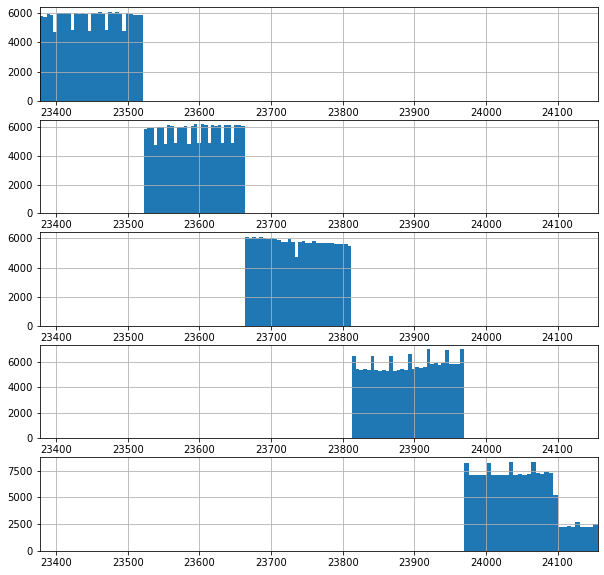

In [26]:
fig, axs = plt.subplots(5, figsize=(10,10))
xlim = (df_combined_w_fold['cum_month'].min(), df_combined_w_fold['cum_month'].max())
for fold in range(n_folds):
    df_combined_w_fold[df_combined_w_fold['fold'] == fold]['cum_month'].hist(ax=axs[fold], bins=30)
    axs[fold].set_xlim(xlim)

# Append test/train id for each station
### for site-specific models, we have to make sure not to include all the data for cross_val_predict (have to set aside the test portion)

In [27]:
for i, (skn, group) in df_combined.groupby('skn'):
    train, test = 

,skn,year,month,data_in,name,lat,lon,elevation,Observer,Status2010,...,skt_4,skt_5,slp_0,slp_1,slp_2,slp_3,slp_4,slp_5,season_dry,season_wet
0,1.00,1948,2,1.330000,KALAE,18.916176,-155.674994,35.0,USCG,Discontinued,...,22.195730,22.042482,1015.34310,1015.23580,1015.47690,1016.23553,1015.97990,1015.8755,0,1
1,2.00,1948,2,2.780000,MANUKA,19.108660,-155.825545,1750.0,STATE DIV OF FTRY,Current,...,22.195730,22.042482,1015.34310,1015.23580,1015.47690,1016.23553,1015.97990,1015.8755,0,1
2,2.20,1948,2,1.210000,KAHUKU SHED 3,19.164740,-155.682280,4890.0,KAHUKU RANCH,Discontinued,...,22.195730,22.042482,1015.34310,1015.23580,1015.47690,1016.23553,1015.97990,1015.8755,0,1
3,2.25,1948,2,2.317491,RESERVOIR (2940),19.160603,-155.822488,2940.0,PUUWAAWAA RANCH,Discontinued,...,22.195730,22.042482,1015.34310,1015.23580,1015.47690,1016.23553,1015.97990,1015.8755,0,1
4,2.26,1948,2,2.516542,CASTLE,19.225323,-155.778876,5680.0,PUUWAAWAA RANCH,Discontinued,...,22.195730,22.042482,1015.34310,1015.23580,1015.47690,1016.23553,1015.97990,1015.8755,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160992,1117.80,2012,5,3.160000,Hanalei,22.198500,-159.495300,16.0,Hydronet,Current,...,24.063688,23.491749,1018.06537,1018.20557,1018.53784,1019.63010,1019.50745,1019.5371,1,0
160993,1134.00,2012,5,1.950000,KILAUEA,22.211941,-159.407202,315.0,RAPOZO N,Current,...,24.063688,23.491749,1018.06537,1018.20557,1018.53784,1019.63010,1019.50745,1019.5371,1,0
160994,1137.00,2012,5,2.330000,KOLOKO RES,22.181408,-159.377758,735.0,KILAUEA SUGAR,Current,...,24.063688,23.491749,1018.06537,1018.20557,1018.53784,1019.63010,1019.50745,1019.5371,1,0
160995,1145.00,2012,5,1.050000,PUU AUAU,22.182760,-159.332203,330.0,LIHUE PLANTATION,Current,...,24.063688,23.491749,1018.06537,1018.20557,1018.53784,1019.63010,1019.50745,1019.5371,1,0


In [31]:
train, test = train_test_split(df_combined[df_combined['skn'] == 1.2], test_size = 0.2, shuffle=False)

In [33]:
train[['year', 'month']]

,year,month
161307,1965,3
162519,1965,4
163735,1965,5
164941,1965,6
166138,1965,9
167371,1966,2
168635,1966,5
169849,1966,6
171085,1966,8
172306,1966,9


In [34]:
test[['year', 'month']]

,year,month
50295,1969,1
51540,1969,2
52778,1969,5
54006,1969,9
46544,1965,10
48988,1966,3
50233,1966,4
51443,1966,12
52662,1967,4
53877,1968,6


In [38]:
train['test'] = np.zeros(train.shape[0]).astype(int)
test['test'] = np.zeros(train.shape[0]).astype(int)

In [48]:
train_, test_ = train_test_split(np.ones(shape=6), test_size=0.2)
train_, test_

(array([1., 1., 1., 1.]), array([1., 1.]))